In [1]:
try:
    from google.colab import auth
    from google.colab import drive

    auth.authenticate_user()
    print('Authenticated')
    drive.mount('/content/drive')

    !pip install -q tensorflow-recommenders
    !pip install -q scann
except:
    IN_COLAB = False

In [3]:
from typing import Dict, Text
import os

from google.cloud import bigquery
from google.cloud.bigquery_storage_v1beta1 import BigQueryStorageClient
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

# Dataset
We use the interaction between user ans product for user that has at least 2 orders to build a model

In [5]:
MINIMUM_PRODUCTS = 5
MINIMUM_ORDERS = 2
data_project_id = "peya-food-and-groceries"
data_dataset_id = "user_fiorella_dirosario"
data_table_orders = "order_sep2020_sep2021"
data_table_order_details = "order_details_sep2020_sep2021"
data_table_users = "attributes_sep2020_sep2021"
data_table_products = "product_attributes_sep2020_sep2021"

interaction_query_train = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    CAST(uo.user_id AS STRING) AS user_id
  , CAST(od.gtin AS STRING) AS product_id
  --, uo.order_id
  --, uo.timestamp
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON uo.order_id = od.order_id
LEFT JOIN products_by_user pbu ON pbu.user_id = uo.user_id
WHERE uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id != pbu.last_order_id 
"""

interaction_query_test = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    CAST(uo.user_id AS STRING) AS user_id
  , CAST(od.gtin AS STRING) AS product_id
  --, uo.order_id
  --, uo.timestamp
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON 
  pbu.user_id = uo.user_id
WHERE 
  uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id = pbu.last_order_id 
"""

product_query = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};


WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT od.gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
    HAVING 
      cant_products >= minimum_products AND cant_orders >= minimum_orders
)
, products AS (
  SELECT DISTINCT
    od.gtin
  FROM
    `{data_project_id}.{data_dataset_id}.{data_table_order_details}` od
  JOIN 
    `{data_project_id}.{data_dataset_id}.{data_table_orders}` uo ON uo.order_id = od.order_id
  JOIN 
    products_by_user pbu ON pbu.user_id = uo.user_id
  WHERE od.gtin IS NOT NULL AND od.has_gtin = 1
)

SELECT 
    CAST(pa.gtin AS STRING) AS product_id
  , IF(pa.category_id IS NULL, "", CAST(pa.category_id AS STRING))  AS category_id
  , IF(pa.brand_id IS NULL, "", CAST(pa.brand_id AS STRING)) AS brand_id
  , CAST(pa.age AS STRING) AS age
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` pa
JOIN products p ON p.gtin = pa.gtin
"""

user_query = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
    uo.user_id
    , COUNT(DISTINCT gtin) as cant_products
    , COUNT(DISTINCT uo.order_id) as cant_orders
    , MAX(uo.order_id) as last_order_id
    FROM 
    `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
    `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON uo.order_id = od.order_id  
    WHERE uo.user_id IS NOT NULL
    AND od.gtin IS NOT NULL
    AND od.has_gtin = 1
    GROUP BY 1
)
SELECT 
    CAST(ua.user_id AS STRING) AS user_id
  , CAST(ua.city_id AS STRING) AS city_id
  , ua.platform
  , IF(ua.segment IS NULL, "Not set", ua.segment) AS segment
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_users}` ua
LEFT JOIN products_by_user pbu ON pbu.user_id = ua.user_id
WHERE cant_products >= minimum_products
      AND cant_orders >= minimum_orders
"""



In [ ]:
project_id = "peya-data-analyt-factory-stg"  #@param ["peya-data-analyt-factory-stg", "peya-food-and-groceries", "peya-growth-and-onboarding"]
client = bigquery.client.Client(project=project_id)
bq_storage_client = BigQueryStorageClient()

interactions_train = (
    client.query(interaction_query_train)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)

interactions_test = (
    client.query(interaction_query_test)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)

users = (
    client.query(user_query)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)
products = (
    client.query(product_query)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)

user_ids = users["user_id"].unique().tolist()
product_ids = products["product_id"].unique().tolist()

In [6]:
interactions_train_ds = tf.data.Dataset.from_tensor_slices(interactions_train.to_dict(orient="list"))
interactions_train_ds = interactions_train_ds.map(lambda x: {"user_id": x["user_id"], "product_id": x["product_id"]})

users_ds = tf.data.Dataset.from_tensor_slices(users.to_dict(orient="list"))
products_ds = tf.data.Dataset.from_tensor_slices(products.to_dict(orient="list"))

tf.random.set_seed(42)
interactions_train_ds = interactions_train_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

for k in interactions_train_ds.take(1).as_numpy_iterator():
    print(k)
for k in products_ds.take(1).as_numpy_iterator():
    print(k)
for k in users_ds.take(1).as_numpy_iterator():
    print(k)

{'user_id': b'6191152', 'product_id': b'7790742770103'}
{'product_id': b'07790139003654', 'category_id': b'335', 'brand_id': b'8735', 'age': b'511'}
{'user_id': b'2442587', 'city_id': b'872', 'platform': b'IPHONE', 'segment': b'Explorer'}


In [7]:
products_ds = products_ds.map(lambda x: x["product_id"])
users_ds = users_ds.map(lambda x: x["user_id"])

# Modeling (matrix factorization)
The mos simple recommendation system model is a matrix factorization, so we build a FM using a Tensorflow to learn the user and product embedding or latent vector. The idea is get a numeric representation of users and product and then get the dot product to get the implicit preferences.
[Reference](https://www.tensorflow.org/recommenders/examples/basic_retrieval)

In [8]:
class MarketsModel(tfrs.Model):

    def __init__(
            self,
            user_model: tf.keras.Model,
            product_model: tf.keras.Model,
            task: tf.keras.layers.Layer
    ):
        super().__init__()
        self.user_model = user_model
        self.product_model = product_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(
            self,
            features: Dict[Text, tf.Tensor],
            training=False
    ) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_product_embeddings = self.product_model(features["product_id"])
        compute_metrics = False if training else True
        return self.task(
            user_embeddings,
            positive_product_embeddings,
            compute_metrics=compute_metrics
        )

In [ ]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=tf.convert_to_tensor(user_ids),
        mask_token=None
    ),
    tf.keras.layers.Embedding(len(user_ids) + 1, embedding_dimension)
])

product_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=tf.convert_to_tensor(product_ids)
        , mask_token=None
    ),
    tf.keras.layers.Embedding(len(product_ids) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
    candidates=products_ds.batch(128).map(product_model)
)

task = tfrs.tasks.Retrieval(
    metrics=metrics
)

In [9]:
model = MarketsModel(user_model, product_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


In [10]:
cached_train = interactions_train_ds.batch(8192).cache()
history = model.fit(cached_train, epochs=5)

Epoch 1/5
1557/1557 [==============================] - 52s 32ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 69880.6366 - regularization_loss: 0.0000e+00 - total_loss: 69880.6366
Epoch 2/5
1557/1557 [==============================] - 24s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 65933.9484 - regularization_loss: 0.0000e+00 - total_loss: 65933.9484
Epoch 3/5
1557/1557 [==============================] - 24s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.

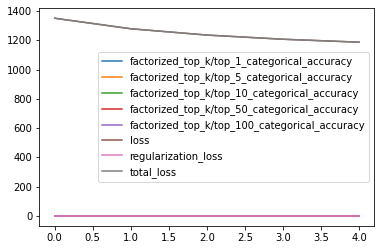

In [12]:
pd.DataFrame(history.history).plot()


## Inference
### BruteForce
Brute force compute the product between user and all product.

In [ ]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    tf.data.Dataset.zip((products_ds.batch(100), products_ds.batch(100).map(model.product_model)))
)

Recommendations for user 42: [b'7791337002012' b'7790742172006' b'7791337000926' b'7791813421580'
 b'7790742333605' b'7790895010088' b'7791813421917' b'7790742172105'
 b'7796989075803' b'7791337001978']


In [ ]:
# Get recommendations.
score, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :20]}")

In [ ]:
% timeit _, titles = index(tf.constant(["42"]))

1000 loops, best of 5: 1.51 ms per loop


## ScaNN
Scann is an efficient Nearest neighbor approximation to retrieve the top k product

In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann.index_from_dataset(
    tf.data.Dataset.zip((products_ds.batch(100), products_ds.batch(100).map(model.product_model)))
)

In [ ]:
score, titles = scann(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :20]}")

Recommendations for user 42: [b'7790742172006' b'7791337002012' b'7791337001961' b'7791337000926'
 b'7790957000545' b'7793890253320' b'7791337002401' b'7791813421580'
 b'7791337091580' b'7790742165909']


In [ ]:
% timeit score, titles = scann(tf.constant(["42"]))


1000 loops, best of 5: 1.89 ms per loop


# Export predictions to BQ

In [ ]:
step = 1000
len_queries = len(user_ids)
partial_result = []

for k in range(0, len_queries, step):
    rec_score, rec_products = index(tf.constant([user_ids[k:k + step]]))
    partial_result.append([rec_score.numpy(), rec_products.numpy()])

recommendation = np.concatenate([k[1] for k in partial_result], axis=0).squeeze()
recommendation = pd.DataFrame(recommendation, index=user_ids).stack().reset_index()
recommendation.columns = ["user_id", "rank", "product_id"]
recommendation['product_id'] = recommendation['product_id'].apply(lambda x: x.decode())

recommendation

,user_id,rank,product_id
0,4655437,0,8480017203809
1,4655437,1,77912268
2,4655437,2,7791813050520
3,4655437,3,8480017300768
4,4655437,4,7798130951776
...,...,...,...
4363445,35417324,5,7790828102095
4363446,35417324,6,7790022000357
4363447,35417324,7,7790383000102
4363448,35417324,8,7790070508348


In [ ]:
result_project_name = "peya-food-and-groceries"
result_dataset_name = "user_fiorella_dirosario"
result_table_name = "user_recommendation_baseline"

recommendation.to_gbq(
    destination_table=f"{result_dataset_name}.{result_table_name}",
    project_id=result_project_name,
    if_exists="replace"
)

1it [00:49, 49.53s/it]


# Saving Model


In [ ]:
if IN_COLAB:
    ouput_path = "/content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/"  #@param ["/content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/", "/content/models/"]
else:
    ouput_path = "../models/"

In [ ]:
path = os.path.join(ouput_path, "base_line_model", "index_model")
if not os.path.exists(path):
    os.makedirs(path)
tf.saved_model.save(index, path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/base_line_index/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/base_line_index/assets


In [ ]:
query_model_path = os.path.join(ouput_path, "base_line_model", "query_model")
if not os.path.exists(query_model_path):
    os.makedirs(query_model_path)
model.user_model.save(query_model_path)

In [ ]:
candidate_model_path = os.path.join(ouput_path, "base_line_model", "candidate_model")

if not os.path.exists(candidate_model_path):
    os.makedirs(candidate_model_path)
model.product_model.save(candidate_model_path)